<a href="https://colab.research.google.com/github/fjxmlinyang/RNN_LSTM_stock_price_prediction/blob/main/Yang_stock_prediction_lstm_proj2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Predictor RNN(LSTM)** 




# Part 0: Pytorch LSTM Stock Predictor



In this porject, we perform a time series prediction for stock price.
1. The data set is 5 years apple stock dataset.
2. We employ a Recurrent Neural Network(RNN) regressor, specifically [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimziation of RNNs.
3. We pridict the stock price in 7 days in advance.
4. This is a Pytorch version of the original Keras LSTM Stock Predictor provided by [Super DataScience](https://www.superdatascience.com/deep-learning/), and also available elsewhere in this repo as a notebook.

# Part 1: Data Exploration



In [ ]:
# download the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DeepLearningRNNProject/all_stocks_5yr.csv")


In [ ]:
dataset

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


In [ ]:
import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader


# we only focus on the close price
dataset_cl = dataset[dataset ['Name']=='AAL'].close.values


In [ ]:
dataset

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


# Part 2: Data Processing/ ETL

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/tonylaioffer/stock-prediction-lstm-using-keras/raw/master/images/timeseries_windowing_training.gif" width=600 height=288/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 4 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now let's window the input time series as described above!  

## Step 1: Feature Scaling


In [ ]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0,1))

# Scale the data
dataset_cl = dataset_cl.reshape(dataset_cl.shape[0], 1)
dataset_cl = sc.fit_transform(dataset_cl)

## Step 2: Cutting time series data into sequences

Time series is a sequence of numbers that we can represent in general mathematically as
$$s_{0}, s_{1}, s_{2}, \cdots, s_{P} $$

where $s_{p}$ is the predictied value of the time series at time period $p$ and where $P$ is the total length of the series. 

In order to apply RNN, we treat the time series predcition problem as a regression problem, and so we need to us a sliding window to construct a set of associated input/output pairs to regress on. We can see the gif below:

<img src="https://github.com/tonylaioffer/stock-prediction-lstm-using-keras/raw/master/images/timeseries_windowing_training.gif" width=600 height=288/>

In this example, we can see if we use a window of size T = 5, the input/output pairs are shown in the table below.

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice that each input is a sequence(or vector) of length 4(in general the window size is T) while each corresponding output is a scalar value. 

Also, notice that given a time series of length P and window size T = 5, we created P - 5 input/output pairs. (In general, for a window size T, we created P - T such pairs.)

In [ ]:
# Create a function to process the data into 7 day look back slices

def processData(data, lb):
    X, y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i : i+ lb, 0])
        y.append(data[(i+ lb), 0])
    return np.array(X), np.array(y)

X, y = processData(dataset_cl, 7)


## Step 3: Split training and testing sets

We split the dataset to 2/3 training and tseting dataset.

Since it is a time series dataset, we won't split the dataset randomly. We don't want to validate our model by traning on random subset of the series and then testing another random subset since the input/output pairs are related temporally. 

Here we will train on one solid chunk of the series, and validate on a later chunck as this simulate how we would predict future values of a time series.


In [ ]:
X_train, X_test = X[: int(X.shape[0]*0.8)], X[int(X.shape[0]*0.8) :]
y_train, y_test = y[: int(y.shape[0]*0.8)], y[int(y.shape[0]*0.8) :]

In [ ]:
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

1000
251
1000
251


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [ ]:
X_train

array([[[0.03806381, 0.03168317, 0.02750275, ..., 0.02134213,
         0.03256326, 0.02728273]],

       [[0.03168317, 0.02750275, 0.03608361, ..., 0.03256326,
         0.02728273, 0.00682068]],

       [[0.02750275, 0.03608361, 0.02134213, ..., 0.02728273,
         0.00682068, 0.00770077]],

       ...,

       [[0.76765677, 0.80462046, 0.74653465, ..., 0.68712871,
         0.68272827, 0.68184818]],

       [[0.80462046, 0.74653465, 0.70143014, ..., 0.68272827,
         0.68184818, 0.6860286 ]],

       [[0.74653465, 0.70143014, 0.68712871, ..., 0.68184818,
         0.6860286 , 0.71023102]]])

In [ ]:
X_test

array([[[0.70143014, 0.68712871, 0.68272827, ..., 0.6860286 ,
         0.71023102, 0.70737074]],

       [[0.68712871, 0.68272827, 0.68184818, ..., 0.71023102,
         0.70737074, 0.7049505 ]],

       [[0.68272827, 0.68184818, 0.6860286 , ..., 0.70737074,
         0.7049505 , 0.73223322]],

       ...,

       [[0.9190319 , 0.88074807, 0.88118812, ..., 0.87062706,
         0.90869087, 0.8990099 ]],

       [[0.88074807, 0.88118812, 0.87260726, ..., 0.90869087,
         0.8990099 , 0.85984598]],

       [[0.88118812, 0.87260726, 0.87062706, ..., 0.8990099 ,
         0.85984598, 0.80836084]]])

# Part 3:  Model Training
## Step 1: Build and run an RNN regression model

We use Keras to build a two hidden layer RNN of the following specifications:
- layer 1 uses an LSTM module with 5 hidden units( the input_shape = (window_size, 1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used


In [ ]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout = 0.1, bidirectional = True):
        super(RNN, self).__init__()
        self.num_directions = bidirectional + 1
        # here directly using LSTM
        self.rnn = nn.LSTM(
            input_size = i_size,
            hidden_size = h_size,
            num_layers = n_layers,
            dropout = dropout,
            bidirectional = bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)

        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, self.num_directions, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state

In [ ]:
# Globals

INPUT_SIZE = 7
HIDDEN_SIZE = 64
NUM_LAYERS = 3
OUTPUT_SIZE = 1
BATCH_SIZE = 128

# Hyper parameters

learning_rate = 0.001
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [ ]:
rnn

RNN(
  (rnn): LSTM(7, 64, num_layers=3, dropout=0.1)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
"""

class StockDateset(Dataset):
    def __init__(self, X_dataset, y_dataset):
        
        self.X_dataset = torch.from_numpy(X_dataset)
        self.y_dataset = torch.from_numpy(y_dataset)

    def __len__(self):
        return np.shape(self.y_dataset)[0]

    def __getitem__(self, idx):

        sample = {'Sequence': self.X_dataset[:, dx, :], 'Target': self.y_dataset[idx]}


        return sample

"""

"\n\nclass StockDateset(Dataset):\n    def __init__(self, X_dataset, y_dataset):\n        \n        self.X_dataset = torch.from_numpy(X_dataset)\n        self.y_dataset = torch.from_numpy(y_dataset)\n\n    def __len__(self):\n        return np.shape(self.y_dataset)[0]\n\n    def __getitem__(self, idx):\n\n        sample = {'Sequence': self.X_dataset[:, dx, :], 'Target': self.y_dataset[idx]}\n\n\n        return sample\n\n"

In [ ]:
# Train_ds = StockDataset(X_train, y_train)

In [ ]:
history = []
X_test_cuda = torch.tensor(X_test).float().cuda()
y_test_cuda = torch.tensor(y_test).float().cuda()


# we use all the data in one batch
inputs_cuda = torch.tensor(X_train).float().cuda()
labels_cuda = torch.tensor(y_train).float().cuda()



for epoch in range(num_epochs):
    rnn.train()
    output, _ = rnn(inputs_cuda, hidden_state)
    # print(output.size())

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward()  # back propagation
    optimiser.step() # update the parameters


    if epoch % 20 == 0:
        rnn.eval()
        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss{}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

epoch 0, loss 0.44208452105522156, eval loss0.7419434785842896
epoch 1, loss 0.40390121936798096
epoch 2, loss 0.3656897246837616
epoch 3, loss 0.3271057903766632
epoch 4, loss 0.2872694730758667
epoch 5, loss 0.24480898678302765
epoch 6, loss 0.1988096684217453
epoch 7, loss 0.15032464265823364
epoch 8, loss 0.10088495910167694
epoch 9, loss 0.05256478488445282
epoch 10, loss 0.025014398619532585
epoch 11, loss 0.045932285487651825
epoch 12, loss 0.08243276178836823
epoch 13, loss 0.07854756712913513
epoch 14, loss 0.054767023772001266
epoch 15, loss 0.034640368074178696
epoch 16, loss 0.02577621303498745
epoch 17, loss 0.025591395795345306
epoch 18, loss 0.030089832842350006
epoch 19, loss 0.034453097730875015
epoch 20, loss 0.03881591558456421, eval loss0.1027970239520073
epoch 21, loss 0.040854569524526596
epoch 22, loss 0.040193475782871246
epoch 23, loss 0.03812113776803017
epoch 24, loss 0.034687239676713943
epoch 25, loss 0.030134469270706177
epoch 26, loss 0.025602517649531364

In [ ]:
rnn.out.weight

Parameter containing:
tensor([[-2.0882e-02, -4.3410e-02,  7.7251e-02,  6.4778e-02,  3.2060e-02,
          1.2014e-01, -7.2752e-02,  1.8920e-02,  8.9284e-02,  9.6497e-02,
          9.7402e-02, -2.1957e-02,  1.2510e-01, -7.9097e-02, -1.6775e-02,
         -4.6854e-03, -8.9196e-02, -9.8209e-02,  4.7076e-02,  1.2257e-01,
         -1.2550e-01, -1.0602e-01, -4.0610e-02, -1.2055e-01,  5.1671e-02,
         -2.1010e-02, -1.1161e-01, -8.0889e-02,  7.6707e-02, -2.5016e-02,
         -3.0555e-02, -1.0538e-01, -1.0426e-01,  1.0342e-01,  1.0444e-01,
          1.0807e-02,  1.0712e-01,  4.7160e-02,  7.0664e-02,  7.2020e-02,
         -6.8133e-02,  5.7144e-02,  1.1230e-01, -9.9358e-02,  7.3684e-02,
          4.5033e-02,  1.0406e-01, -4.0340e-02, -5.7418e-02,  1.2270e-01,
         -4.7200e-02, -6.6270e-02, -8.7673e-02, -3.0102e-02,  5.9268e-03,
          3.3888e-02, -9.5499e-05, -8.0123e-02, -1.0177e-01,  5.8222e-02,
          6.4766e-02,  9.4473e-02, -7.1947e-02, -4.0016e-02]], device='cuda:0',
       req

In [ ]:
for param in rnn.parameters():
    print(param.data)

tensor([[-0.0641,  0.0689,  0.1051,  ..., -0.0442,  0.1051, -0.0439],
        [-0.0820, -0.0391,  0.0213,  ...,  0.1278, -0.0206, -0.0416],
        [-0.0702, -0.1232, -0.1221,  ..., -0.1065,  0.0462, -0.0162],
        ...,
        [ 0.1077,  0.0373,  0.0772,  ..., -0.0376,  0.1124,  0.0461],
        [-0.0852,  0.0650, -0.0441,  ..., -0.0319,  0.0699, -0.1143],
        [-0.0989,  0.1028, -0.0547,  ..., -0.0074, -0.0386, -0.0923]],
       device='cuda:0')
tensor([[-0.0970,  0.0750,  0.0838,  ..., -0.0800,  0.0307, -0.0317],
        [-0.0132, -0.1143,  0.0193,  ...,  0.1051, -0.0428, -0.0995],
        [-0.0201,  0.1119,  0.0581,  ...,  0.0446,  0.1133, -0.0889],
        ...,
        [ 0.0216, -0.1300,  0.0660,  ...,  0.0668, -0.0340, -0.0381],
        [ 0.0997, -0.0690,  0.0630,  ..., -0.1147,  0.0938,  0.0029],
        [ 0.0923,  0.0030,  0.1212,  ..., -0.0271, -0.0988,  0.0595]],
       device='cuda:0')
tensor([ 5.2245e-02, -9.8756e-02,  3.9452e-02, -5.2998e-02, -1.8667e-02,
         2.

# Part 4: Model performance/ Model Evaluation

With our model fit we can now make predictions on both our training and testing sets.

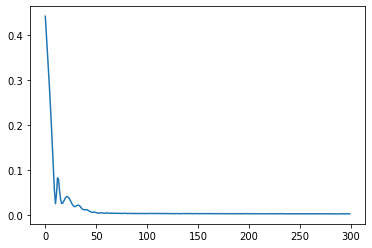

In [ ]:
plt.plot(history)
# dplt.plot(history.history['val_loss'])

In [ ]:
X_test[0]

array([[0.70143014, 0.68712871, 0.68272827, 0.68184818, 0.6860286 ,
        0.71023102, 0.70737074]])

In [ ]:
# X_train_X_test = np.concatenate((X_train, X_test), axis=0)
# hidden_state = None


rnn.eval()

# test_inputs = torch.tensor(X_test).float().cuda()

test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()


In [ ]:
test_predict_cpu.shape

(251, 1, 1)

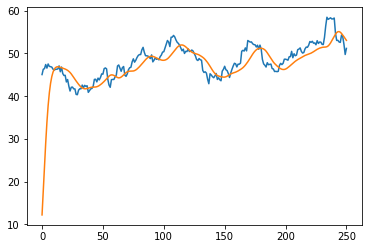

In [ ]:
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict_cpu.reshape(-1,1)))

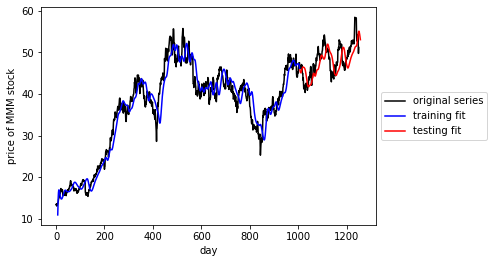

In [ ]:
# plot original data

plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()


# use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()



# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0] * 0.80) + 7 #window_size
plt.plot(np.arange(7, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt +len(test_predict_cpu), 1), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')


# pretty up graph

plt.xlabel('day')
plt.ylabel('price of MMM stock')
plt.legend(['original series', 'training fit', 'testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
